In [1]:
import Model
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
#from tensorflow.keras.models import Model
from tqdm import tqdm 
import time
import os
import re
import hashlib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import SpeechGenerator
import librosa
#from keras import losses
import python_speech_features as sf

from extractMFCC import computeFeatures, computeFeatures1
from addNoise import addNoise

tf.enable_eager_execution()
print(tf.executing_eagerly())
print(tf.__version__)
print(tf.keras.__version__)

Using TensorFlow backend.


True
1.14.0
2.2.4-tf


In [2]:
# Root folder of the dataset
dataset_dir = "Dataset/"

In [3]:
# File containing the path that identify the test and validation set
testWAVs = pd.read_csv(dataset_dir + 'testing_list.txt', sep=" ", header = None)[0].tolist()
valWAVs  = pd.read_csv(dataset_dir + 'validation_list.txt', sep=" ", header = None)[0].tolist()

In [4]:
# Dictionary containing the mapping between category name and label
DictCategs = {'nine' : 1, 'yes' : 2, 'no' : 3, 'up' : 4, 'down' : 5, 'left' : 6, 'right' : 7, 'on' : 8, 'off' : 9, 
              'stop' : 10, 'go' : 11, 'zero' : 12, 'one' : 13, 'two' : 14, 'three' : 15, 'four' : 16, 'five' : 17, 
              'six' : 18, 'seven' : 19, 'eight' : 20, 'backward':21, 'bed':22, 'bird':23, 'cat':24, 'dog':25, 'follow':26, 
              'forward':27, 'happy':28, 'house':29, 'learn':30, 'marvin':31, 'sheila':32, 'tree':33, 'visual':34, 'wow':0,
              '_background_noise_':0 }
nCategs = 35

In [5]:
# Load all the file in dataset
allWAVs  = []
for root, dirs, files in os.walk('Dataset/'):
    for f in files:
        if (root != dataset_dir + "_background_noise_") and (f.endswith('.wav')):
            path = root + "/" + f
            #print(path)
            path = path[len(dataset_dir):]
            #print(path)
            allWAVs.append(path)

# Remove from the training set the elements present in test and validation
trainWAVs = list(set(allWAVs) - set(valWAVs) - set(testWAVs))

In [6]:
# Size of sets
print("Train set length: " + str(len(trainWAVs)))
print("Validation set length: " + str(len(valWAVs)))
print("Test set length: " + str(len(testWAVs)))

Train set length: 84843
Validation set length: 9981
Test set length: 11005


In [7]:
# Function to extract the category from the path to the file
def _getFileCategory(file, catDict):
    # Receives a file with name <cat>/<filename> and returns an integer that is catDict[cat]
    categ = os.path.basename(os.path.dirname(file))
    return catDict.get(categ, 0)

In [8]:
# Get categories of each set
testWAVlabels = [_getFileCategory(f, DictCategs) for f in testWAVs]
valWAVlabels = [_getFileCategory(f, DictCategs) for f in valWAVs]
trainWAVlabels = [_getFileCategory(f, DictCategs) for f in trainWAVs]

# And test the size of the labels set
print("Train-Labels set length: " + str(len(trainWAVlabels)))
print("Validation-Labels set length: " + str(len(valWAVlabels)))
print("Test-Labels set length: " + str(len(testWAVlabels)))

Train-Labels set length: 84843
Validation-Labels set length: 9981
Test-Labels set length: 11005


In [9]:
# Transoform the train dataset in numpy array and load them 
train = np.array(trainWAVs, dtype = object)
trainLabels = np.array(trainWAVlabels, dtype = '>i4') #stands for int32

print("Loading of the train set:")
for i in range(len(trainWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(trainWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + trainWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + trainWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + trainWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    train[i] = trainWAVs[i] + '.npy'
    
print(str(i+1) + '/' + str(len(trainWAVs)))

Loading of the train set:
0/84843
5000/84843
10000/84843
15000/84843
20000/84843
25000/84843
30000/84843
35000/84843
40000/84843
45000/84843
50000/84843
55000/84843
60000/84843
65000/84843
70000/84843
75000/84843
80000/84843
84843/84843


In [10]:
# Do the same thing for the validation and the test set
val = np.array(valWAVs, dtype = object)
valLabels = np.array(valWAVlabels, dtype = '>i4') #stands for int32

print("Loading of the validation set:")
for i in range(len(valWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(valWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + valWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + valWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + valWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    val[i] = valWAVs[i] + '.npy'
    
print(str(i+1) + '/' + str(len(valWAVs)))

test = np.array(testWAVs, dtype = object)

print("Loading of the test set:")
for i in range(len(testWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(testWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + testWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + testWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + testWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    test[i] = testWAVs[i] + '.npy' 
    
print(str(i+1) + '/' + str(len(testWAVs)))

Loading of the validation set:
0/9981
5000/9981
9981/9981
Loading of the test set:
0/11005
5000/11005
10000/11005
11005/11005


In [11]:
#test on the length
print(str(len(trainWAVs)) + " = " + str(len(train)))
print(str(len(valWAVs)) + " = " + str(len(val)))
print(str(len(testWAVs)) + " = " + str(len(test)))

#test on labels 
for i in range(0, 1):
    print("file: " + train[i] + " - label: " + str(trainLabels[i]))
    print("file: " + trainWAVs[i] + " - label: " + str(trainLabels[i]))

84843 = 84843
9981 = 9981
11005 = 11005
file: six/3a3ee7ed_nohash_0.wav.npy - label: 18
file: six/3a3ee7ed_nohash_0.wav - label: 18


Text(0.5, 1.0, 'WAV signal')

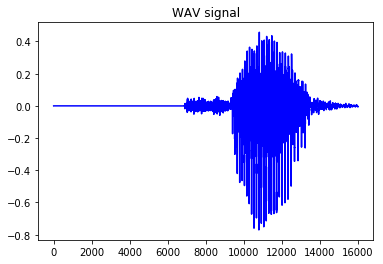

In [12]:
# Function to load numpy array
def load_data(file_name, data_dir):
    # Load the wav signal from the .npy file
    data = np.load(data_dir + file_name)
    return data

# Plot a wav
file_name = train[124]
data = load_data(file_name, dataset_dir)
plt.figure()
plt.plot(data, color='b')
plt.title('WAV signal')

(100, 80)


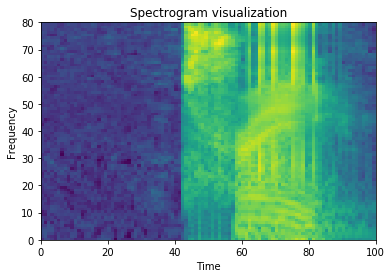

File: three/7213ed54_nohash_0.wav.npy - Label: 15
[[-1.1982434  -0.87078476 -0.8790983  ...  0.24955381  0.20580037
   0.35666147]
 [-0.90859663 -0.7137412  -1.1185529  ...  0.45027867  0.3793461
   0.31602558]
 [-0.7916696  -0.69894487 -0.90589523 ...  0.53596866  0.41640294
   0.2951695 ]
 ...
 [-0.94068545 -0.91359645 -0.98926765 ... -0.6355557  -0.97429836
  -1.3077564 ]
 [-0.9009338  -0.88146055 -0.9575283  ... -0.65665007 -0.85466945
  -1.1711509 ]
 [-0.8905706  -0.9079151  -0.9488502  ... -0.7002361  -0.8016839
  -0.8963907 ]]


In [13]:
# Function to preprocess the data 
def load_and_preprocess_data(file_name, data_dir, noisy = False):
    # Required by tensorflow (strings are passed as bytes)
    if type(file_name) is bytes:
        file_name = file_name.decode()
        data_dir = data_dir.decode()

    # Load data
    data = np.zeros((16000,))
    d = load_data(file_name, data_dir)
    data[:d.shape[0]] = d
    if noisy:
        noise = load_data('_background_noise_/white_noise.wav.npy', dataset_dir)
        data = addNoise1(data, noise, intensity = 0.1) 
    #feats = computeFeatures1(data, 16000)
    # Normalize
    #feats -= np.mean(feats, axis=0)
    #mean = np.mean(feats, axis = 0)
    #stv = np.std(feats, axis = 0)
    #diff = np.subtract(feats, mean)
    #feats = np.divide(diff, stv + 1e-8)
    #feats = np.divide(feats, np.max(feats))
    #diff1 = np.subtract(feats, np.amin(feats, axis=0))
    #print(np.amin(feats, axis=0))
    #print(np.amax(feats, axis=0))
    #diff2 = np.subtract(np.amax(feats, axis=0), np.amin(feats, axis=0))
    #feats = np.divide(diff1, diff2+1e-6)
    y3 = sf.base.logfbank(data, samplerate = 16000, winlen = 0.016, nfilt=80, nfft = 1024, lowfreq = 40, highfreq = 8000, preemph = 0.95)
    #y3 = np.transpose(y3)    
    mean = np.mean(y3, axis=0)
    #print(mean.shape)
    stv = np.std(y3, axis=0)
    #print(stv.shape)
    diff = np.subtract(y3, mean)
    #print(diff.shape)
    y3 = np.divide(diff, stv + 1e-8)

    return y3.astype(np.float32)

# example:
index = 124
feats = load_and_preprocess_data(train[index], dataset_dir, False)
print(feats.shape)
feats = np.transpose(feats)
plt.figure()
plt.pcolormesh(feats)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()
print("File: " + train[index] + " - Label: " + str(trainLabels[index]))
print(feats)

In [14]:
# new dataset for the classifier 
def create_dataset(data_dir, file_names, labels, batch_size = 32, shuffle = True, cache_file = None):
    
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    
    # Map the load_and_preprocess_data function
    py_func = lambda file_name, label: (tf.numpy_function (load_and_preprocess_data, [file_name, data_dir, False], tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls = os.cpu_count())
    
    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)
    
    # Shuffle    
    if shuffle:
        dataset = dataset.shuffle(len(file_names))
        
    # Repeat the dataset indefinitely (capire bene anche questo repeat come funziona)
    dataset = dataset.repeat()
    
    # Correct input shape for the network
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, -1), label))
    
    # Batch
    dataset = dataset.batch(batch_size = batch_size)
    
    # Prefetch (1 means that prefetch a batch at time)
    dataset = dataset.prefetch(buffer_size = 1)
    
    return dataset

In [15]:
batch_size = 128

train_dataset = create_dataset(dataset_dir, train, trainLabels, batch_size = batch_size, shuffle = True, cache_file = 'train_cache')

val_dataset = create_dataset(dataset_dir, val, valLabels, batch_size = batch_size, shuffle = False, cache_file = 'val_cache')

test_dataset = create_dataset(dataset_dir, test, testWAVlabels, batch_size = batch_size, shuffle = False, cache_file = 'test_cache')

train_steps = int(np.ceil(len(train) / batch_size))
val_steps = int(np.ceil(len(val) / batch_size))
test_steps = int(np.ceil(len(test) / batch_size))

print("steps to completa a train epoch: " + str(train_steps))
print("steps to completa a validation spoch: " + str(val_steps))
print("steps to completa a test epoch: " + str(test_steps))

steps to completa a train epoch: 663
steps to completa a validation spoch: 78
steps to completa a test epoch: 86


In [16]:
model = Model.AttentionModel(nCategs, 100, 80, 64, use_GRU = True, dropout = 0.2, activation = 'relu')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 80, 10)  60          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 80, 10)  40          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 80, 1)   31          batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
# questa funzione sembra essere difficile da applicare ad un fit normale, si può provare ma intanto ho provato ad usare 
# l'exp_decay che si da in ingresso all'optimizer
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-1.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [18]:
learning_rate = 0.0001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

In [ ]:
num_epochs = 5
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

Epoch 1/5


W0706 12:23:16.218831 140419143206656 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


662/663 [============================>.] - ETA: 3s - loss: 2.3085 - sparse_categorical_accuracy: 0.3502
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.22105, saving model to Model/AttentionModel-checkpoint-1.h5
663/663 [==============================] - 2536s 4s/step - loss: 2.3071 - sparse_categorical_accuracy: 0.3506 - val_loss: 2.8210 - val_sparse_categorical_accuracy: 0.2211
Epoch 2/5
662/663 [============================>.] - ETA: 3s - loss: 1.2212 - sparse_categorical_accuracy: 0.6478
Epoch 00002: val_sparse_categorical_accuracy improved from 0.22105 to 0.23638, saving model to Model/AttentionModel-checkpoint-1.h5
663/663 [==============================] - 2451s 4s/step - loss: 1.2211 - sparse_categorical_accuracy: 0.6478 - val_loss: 2.8034 - val_sparse_categorical_accuracy: 0.2364
Epoch 3/5
 71/663 [==>...........................] - ETA: 35:01 - loss: 1.0420 - sparse_categorical_accuracy: 0.6963

In [ ]:
#print(history.history.keys())

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'], label = 'Train acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'Val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Save the model
model.save('Model/AttentionModel-1_00-0607-13-35class.h5')

testEval = model.evaluate(test_dataset,
                          steps = test_steps,
                          verbose = 1)

In [ ]:
x = "left/94de6a6a_nohash_2.wav.npy"
x = load_and_preprocess_data(x, dataset_dir).reshape((1, 100, 80, 1))
print(x.shape)
res = model.predict(x) 
print(res.argmax())